In [17]:
import os
import json
import io
import logging
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageCms
from scipy import stats

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

DATA_FOLDER = '/home/beans/Desktop/Projects/color-grade/data'

image_path = os.path.join('/home/beans/Desktop/Projects/color-grade/pictures/', 'goldenHour6.jpg')
image = Image.open(image_path)


In [18]:
def safe_mean(a):
    return np.mean(a) if a.size > 0 else 0

def safe_divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a, dtype=float), where=b!=0)

def safe_std(a):
    return np.std(a) if a.size > 0 else 0

def analyze_tonal_range(channel, low, high):
    mask = (channel >= low) & (channel <= high)
    masked_channel = channel[mask]
    return {
        'mean': float(safe_mean(masked_channel)),
        'std': float(safe_std(masked_channel)),
        'percentage': float(np.sum(mask) / channel.size * 100) if channel.size > 0 else 0
    }


def convert_to_srgb(image):
    try:
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        icc = image.info.get('icc_profile', '')
        if icc:
            io_handle = io.BytesIO(icc)
            src_profile = ImageCms.ImageCmsProfile(io_handle)
            dst_profile = ImageCms.createProfile('sRGB')
            image = ImageCms.profileToProfile(image, src_profile, dst_profile, outputMode='RGB')
    except Exception as e:
        logging.warning(f"Could not convert color profile: {e}")
    return image

In [19]:
def analyze_color_ratios(r, g, b):
    def calculate_ratios(r_vals, g_vals, b_vals):
        r_mean, g_mean, b_mean = safe_mean(r_vals), safe_mean(g_vals), safe_mean(b_vals)
        r_g_ratio = safe_divide(r_mean, g_mean)
        r_b_ratio = safe_divide(r_mean, b_mean)
        g_b_ratio = safe_divide(g_mean, b_mean)
        return float(r_g_ratio), float(r_b_ratio), float(g_b_ratio)

    shadows_mask = (r < 85) & (g < 85) & (b < 85)
    midtones_mask = (r >= 85) & (r < 170) & (g >= 85) & (g < 170) & (b >= 85) & (b < 170)
    highlights_mask = (r >= 170) & (g >= 170) & (b >= 170)

    shadows_ratios = calculate_ratios(r[shadows_mask], g[shadows_mask], b[shadows_mask])
    midtones_ratios = calculate_ratios(r[midtones_mask], g[midtones_mask], b[midtones_mask])
    highlights_ratios = calculate_ratios(r[highlights_mask], g[highlights_mask], b[highlights_mask])

    return {
        'shadows': {'r_g': shadows_ratios[0], 'r_b': shadows_ratios[1], 'g_b': shadows_ratios[2]},
        'midtones': {'r_g': midtones_ratios[0], 'r_b': midtones_ratios[1], 'g_b': midtones_ratios[2]},
        'highlights': {'r_g': highlights_ratios[0], 'r_b': highlights_ratios[1], 'g_b': highlights_ratios[2]}
    }

def analyze_tone_mapping(cdfs):
    def calculate_slope(cdf, start, end):
        return safe_divide(cdf[end] - cdf[start], end - start)

    slopes = {}
    for color, cdf in zip(['red', 'green', 'blue'], cdfs):
        slopes[color] = {
            'shadows': float(calculate_slope(cdf.cumcount, 0, 84)),
            'midtones': float(calculate_slope(cdf.cumcount, 85, 170)),
            'highlights': float(calculate_slope(cdf.cumcount, 171, 255))
        }
    
    return slopes

def analyze_shadow_rolloff(cdfs):
    def calculate_second_derivative(cdf, start, end):
        if end - start < 2:
            return 0
        first_derivative = np.diff(cdf[start:end])
        if len(first_derivative) < 2:
            return 0
        second_derivative = np.diff(first_derivative)
        return float(safe_mean(np.abs(second_derivative)))

    rolloff = {}
    for color, cdf in zip(['red', 'green', 'blue'], cdfs):
        rolloff[color] = calculate_second_derivative(cdf.cumcount, 0, min(50, len(cdf.cumcount)))
    
    return rolloff

def analyze_image(image_path):
    logging.info(f"Analyzing image: {image_path}")
    try:
        img = Image.open(image_path)
        img = convert_to_srgb(img)
        img_array = np.array(img)
        
        # Ensure image is in RGB mode
        if len(img_array.shape) == 2:  # Grayscale image
            img_array = np.stack((img_array,)*3, axis=-1)
        elif img_array.shape[2] == 4:  # RGBA image
            img_array = img_array[:,:,:3]
        
        # Clip values to ensure they're within 0-255 range
        img_array = np.clip(img_array, 0, 255).astype(np.uint8)
        
        r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]
        
        color_stats = {
            'red': {
                'mean': float(safe_mean(r)),
                'std': float(safe_std(r)),
                'median': float(np.median(r))
            },
            'green': {
                'mean': float(safe_mean(g)),
                'std': float(safe_std(g)),
                'median': float(np.median(g))
            },
            'blue': {
                'mean': float(safe_mean(b)),
                'std': float(safe_std(b)),
                'median': float(np.median(b))
            }
        }
        logging.debug(f"Color stats: {color_stats}")
        
        hist_r, _ = np.histogram(r, bins=256, range=(0, 255))
        hist_g, _ = np.histogram(g, bins=256, range=(0, 255))
        hist_b, _ = np.histogram(b, bins=256, range=(0, 255))
        
        cdf_r = stats.cumfreq(r.flatten(), numbins=256, defaultreallimits=(0, 255))
        cdf_g = stats.cumfreq(g.flatten(), numbins=256, defaultreallimits=(0, 255))
        cdf_b = stats.cumfreq(b.flatten(), numbins=256, defaultreallimits=(0, 255))
        
        tonal_ranges = {
            'shadows': {color: analyze_tonal_range(channel, 0, 84) for color, channel in zip(['red', 'green', 'blue'], [r, g, b])},
            'midtones': {color: analyze_tonal_range(channel, 85, 170) for color, channel in zip(['red', 'green', 'blue'], [r, g, b])},
            'highlights': {color: analyze_tonal_range(channel, 171, 255) for color, channel in zip(['red', 'green', 'blue'], [r, g, b])}
        }
        logging.debug(f"Tonal ranges: {tonal_ranges}")
        
        color_ratios = analyze_color_ratios(r, g, b)
        logging.debug(f"Color ratios: {color_ratios}")
        
        tone_mapping = analyze_tone_mapping([cdf_r, cdf_g, cdf_b])
        logging.debug(f"Tone mapping: {tone_mapping}")
        
        shadow_rolloff = analyze_shadow_rolloff([cdf_r, cdf_g, cdf_b])
        logging.debug(f"Shadow rolloff: {shadow_rolloff}")
        
        return color_stats, (hist_r, hist_g, hist_b), (cdf_r, cdf_g, cdf_b), tonal_ranges, color_ratios, tone_mapping, shadow_rolloff
    except Exception as e:
        logging.error(f"Error in analyze_image: {str(e)}")
        raise

In [21]:
def plot_results(image_path, color_stats, histograms, cdfs, tonal_ranges, color_ratios, tone_mapping, shadow_rolloff):
    fig = plt.figure(figsize=(20, 24))
    gs = fig.add_gridspec(4, 3, height_ratios=[2, 1, 1, 1])

    # Increase title font size, make bold, and increase label font size
    title_font = {'fontsize': 18, 'fontweight': 'bold'}
    label_font = {'fontsize': 12}

    # Plot original image
    ax_img = fig.add_subplot(gs[0, :])
    ax_img.imshow(plt.imread(image_path))
    ax_img.set_title('Original Image', **title_font)
    ax_img.axis('off')

    # Plot histograms
    ax_hist = fig.add_subplot(gs[1, 0])
    ax_hist.plot(histograms[0], color='red', alpha=0.7)
    ax_hist.plot(histograms[1], color='green', alpha=0.7)
    ax_hist.plot(histograms[2], color='blue', alpha=0.7)
    ax_hist.set_title('Color Histograms', **title_font)
    ax_hist.set_xlabel('Pixel Value', **label_font)
    ax_hist.set_ylabel('Frequency', **label_font)
    ax_hist.tick_params(labelsize=10)

    # Plot color curves
    ax_cdf = fig.add_subplot(gs[1, 1])
    ax_cdf.plot(cdfs[0].cumcount / cdfs[0].cumcount[-1], color='red', alpha=0.7)
    ax_cdf.plot(cdfs[1].cumcount / cdfs[1].cumcount[-1], color='green', alpha=0.7)
    ax_cdf.plot(cdfs[2].cumcount / cdfs[2].cumcount[-1], color='blue', alpha=0.7)
    ax_cdf.set_title('Color Curves (CDF)', **title_font)
    ax_cdf.set_xlabel('Pixel Value', **label_font)
    ax_cdf.set_ylabel('Cumulative Frequency', **label_font)
    ax_cdf.tick_params(labelsize=10)

    # Display color statistics
    ax_stats = fig.add_subplot(gs[1, 2])
    ax_stats.axis('off')
    ax_stats.set_title('Color Statistics', **title_font)

    colors = ['Red', 'Green', 'Blue']
    stats = ['Mean', 'Std Dev', 'Median']
    cell_text = [
        [f"{color_stats[color.lower()]['mean']:.2f}" for color in colors],
        [f"{color_stats[color.lower()]['std']:.2f}" for color in colors],
        [f"{color_stats[color.lower()]['median']:.2f}" for color in colors]
    ]

    table = ax_stats.table(cellText=cell_text,
                           rowLabels=stats,
                           colLabels=colors,
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    for i, color in enumerate(colors):
        table[(0, i)].set_facecolor(color.lower())
        table[(0, i)].set_text_props(color='white', weight='bold')

    # Plot color ratios
    ax_ratios = fig.add_subplot(gs[2, 0])
    x = np.arange(3)
    width = 0.25
    for i, range_name in enumerate(['shadows', 'midtones', 'highlights']):
        ratios = color_ratios[range_name]
        ax_ratios.bar(x + i*width, [ratios['r_g'], ratios['r_b'], ratios['g_b']], width, label=range_name)
    ax_ratios.set_ylabel('Ratio Value', **label_font)
    ax_ratios.set_title('Color Ratios', **title_font)
    ax_ratios.set_xticks(x + width)
    ax_ratios.set_xticklabels(['R/G', 'R/B', 'G/B'], **label_font)
    ax_ratios.legend(fontsize=10)
    ax_ratios.tick_params(labelsize=10)

    # Plot tone mapping
    ax_tone = fig.add_subplot(gs[2, 1])
    x = np.arange(3)
    width = 0.25
    for i, color in enumerate(['red', 'green', 'blue']):
        slopes = tone_mapping[color]
        ax_tone.bar(x + i*width, [slopes['shadows'], slopes['midtones'], slopes['highlights']], width, label=color)
    ax_tone.set_ylabel('Slope Value', **label_font)
    ax_tone.set_title('Tone Mapping Slopes', **title_font)
    ax_tone.set_xticks(x + width)
    ax_tone.set_xticklabels(['Shadows', 'Midtones', 'Highlights'], **label_font)
    ax_tone.legend(fontsize=10)
    ax_tone.tick_params(labelsize=10)

    # Display tonal range and advanced analyses
    ax_tonal = fig.add_subplot(gs[2:, 2])
    ax_tonal.axis('off')
    ax_tonal.set_title('Tonal Range and Advanced Analyses', **title_font)

    # Prepare data for the table
    ranges = ['Shadows', 'Midtones', 'Highlights']
    colors = ['Red', 'Green', 'Blue']
    metrics = ['Mean', 'Std Dev', '% of Image']

    cell_text = []
    cell_colors = []
    for range_name in ranges:
        for color in colors:
            stats = tonal_ranges[range_name.lower()][color.lower()]
            cell_text.append([
                f"{stats['mean']:.2f}",
                f"{stats['std']:.2f}",
                f"{stats['percentage']:.2f}%"
            ])
            row_colors = ['white', 'white', plt.cm.RdYlGn(stats['percentage'] / 100)]
            cell_colors.append(row_colors)

    # Create table
    # Create table
    table = ax_tonal.table(cellText=cell_text,
                           rowLabels=[f"{r} {c}" for r in ranges for c in colors],
                           colLabels=metrics,
                           cellLoc='center',
                           loc='center',
                           cellColours=cell_colors)

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    # Add Shadow Rolloff information
    rolloff_text = "Shadow Rolloff (2nd Derivative):\n"
    for color, value in shadow_rolloff.items():
        rolloff_text += f"{color.capitalize()}: {value:.6f}\n"

    ax_tonal.text(0.5, -0.1, rolloff_text, fontsize=10, ha='center', va='top', transform=ax_tonal.transAxes)

    # Add a color bar to show the meaning of the color-coded percentages
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=100))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax_tonal, orientation='horizontal', aspect=10, pad=0.2)
    cbar.set_label('Percentage of Image', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    return fig

In [23]:
def save_results(image_path, color_stats, histograms, cdfs, tonal_ranges, color_ratios, tone_mapping, shadow_rolloff, fig):
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    
    # Save JSON data
    json_data = {
        'color_stats': color_stats,
        'histograms': {
            'red': histograms[0].tolist(),
            'green': histograms[1].tolist(),
            'blue': histograms[2].tolist()
        },
        'cdfs': {
            'red': cdfs[0].cumcount.tolist(),
            'green': cdfs[1].cumcount.tolist(),
            'blue': cdfs[2].cumcount.tolist()
        },
        'tonal_ranges': tonal_ranges,
        'color_ratios': color_ratios,
        'tone_mapping': tone_mapping,
        'shadow_rolloff': shadow_rolloff
    }
    json_path = os.path.join(DATA_FOLDER, f'{base_filename}_analysis.json')
    with open(json_path, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    # Save plot
    plot_path = os.path.join(DATA_FOLDER, f'{base_filename}_analysis.png')
    fig.savefig(plot_path)
    plt.close(fig)

In [24]:
def main():
    pictures_dir = 'pictures'
    if not os.path.exists(pictures_dir):
        logging.error(f"The '{pictures_dir}' directory does not exist.")
        return

    if not os.path.exists(DATA_FOLDER):
        os.makedirs(DATA_FOLDER)

    image_files = [f for f in os.listdir(pictures_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]
    
    if not image_files:
        logging.error(f"No image files found in the '{pictures_dir}' directory.")
        return

    for filename in image_files:
        image_path = os.path.join(pictures_dir, filename)
        logging.info(f"Processing {filename}...")
        try:
            results = analyze_image(image_path)
            fig = plot_results(image_path, *results)
            save_results(image_path, *results, fig)
            logging.info(f"Analysis complete for {filename}. Results saved in the data folder.")
        except Exception as e:
            logging.error(f"Error processing {filename}: {str(e)}")

2024-07-10 21:40:48,136 - INFO - Analyzing image: /home/beans/Desktop/Projects/color-grade/pictures/goldenHour6.jpg


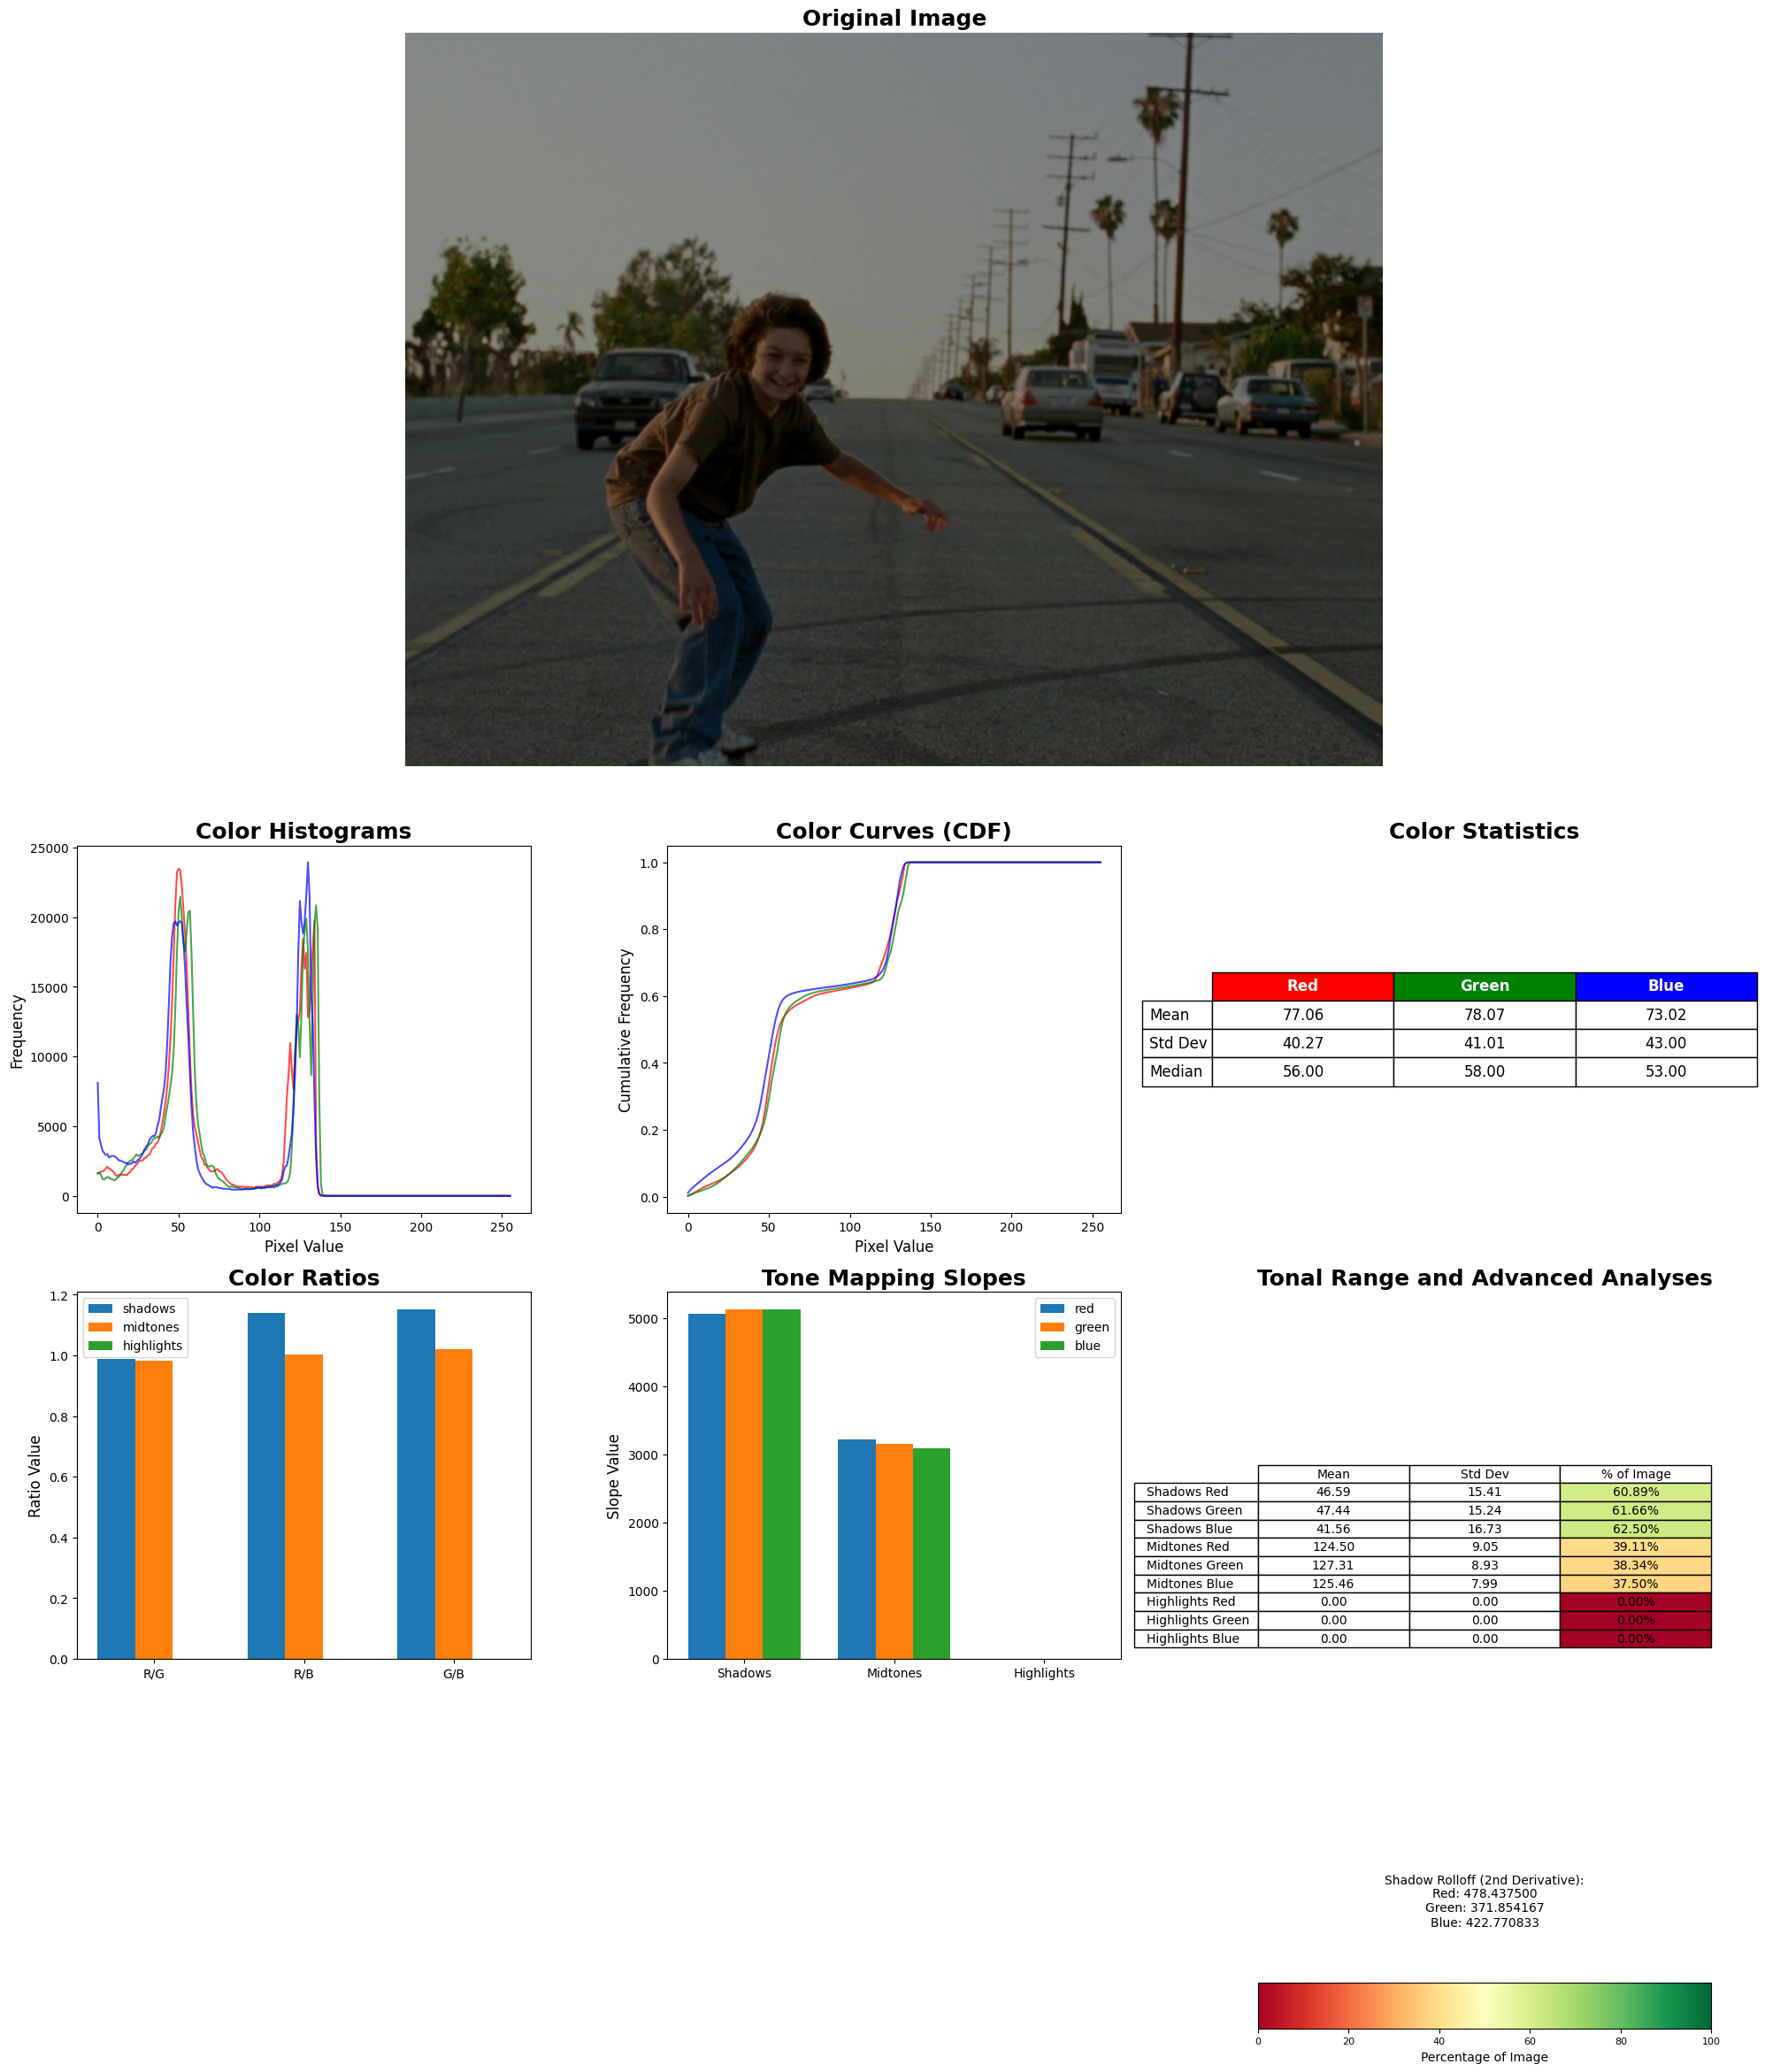

In [25]:
image_path = '/home/beans/Desktop/Projects/color-grade/pictures/goldenHour6.jpg'
color_stats, histograms, cdfs, tonal_ranges, color_ratios, tone_mapping, shadow_rolloff = analyze_image(image_path)

# Now you can call plot_results
fig = plot_results(image_path, color_stats, histograms, cdfs, tonal_ranges, color_ratios, tone_mapping, shadow_rolloff)
plt.show()

